# Using adversarial networks to extend brain computer interface decoding accuracy over time

## The problem -- the performance of a well-calibrated iBCI decoder degrades over time

Intracortical brain-computer interfaces (iBCIs) uses a "decoder" to translate the moment-to-moment neural activity into a signal for intended movements, so as to help restore lost motor functions for people with paralysis (Figure 1A). 

The instability in neural recordings is a major hurdle to the long-term stability of iBCIs. Let's imagine the following case. On day-0, a BCI decoder is well calibrated and learned by the user. As time goes, usually we will see substantial changes in acquired neural signals on day-k. Such changes would hurt the performance of the well-calibrated day-0 decoder a lot (see Figure 1B) so that the intent of the user cannot be accurately predicted any more.    

One way to solve this problem is to simply recalibrate the decoder with newly acquired data. Apparently, the normal use of the BCI system would be interrupted during recalibration, and it will take additional time and efforts for the user to learn the recalibrated decoder.

![fig1](./images/fig1.png)
*Figure 1 A) The decoder for intracortical brain-computer interfaces (iBCIs). B) A well-calibrated decoder could produce accurate estimations of the EMGs on day-0, but failed on day-k.*

## We propose to use adversarial networks to extend brain computer interface decoding accuracy over time

An ideal iBCI would accommodate the instabilities in neural recordings without supervision, thereby minimizing the need to periodically learn new decoders. But, how to do it? 

As mentioned above, it is mainly due to the changes of neural signals from day-0 to day-k that a well-calibrated day-0 decoder failed on day-k. If we apply some transformation on day-k neural signals to make them similar to day-0 neural signals, would the performance of the day-0 decoder be maintained on day-k? [Our preprint](https://www.biorxiv.org/content/10.1101/2022.08.26.504777v1) shows that this notion is feasible to extend BCI decoding accuracy over time. 

In our study, we use Cycle-Consistent Adversarial Networks (Cycle-GAN, Zhu et al., 2017, originally proposed for unpaired image-to-image translation) to implement such transformation on day-k neural signals. The results we obtained showed that even ~3 months after decoder training the performance of the day-0 decoder can be maintained if using Cycle-GAN to **"align"** the full-dimentional neural signals. We call this process **"alignment"**, and use Cycle-GAN as the **"aligner"**. We also showed that Cycle-GAN is easy to train, and such alignment can be done on continuous recordings, which means, there is no need to align trials according to specific behavioral events.

This notebook will walk you through this approach using a dataset collected from a monkey who kept doing a motor task over 90 days.
![fig2](./images/exp_background.png)
*Figure 2 The isometric wrist center-out task*

## Datasets

The datasets are from a monkey (monkey J) doing an isometric wrist torque task. This task requires the monkey to control the cursor on the screen by exerting forces on a small box placed around one of the hands. The box was padded to comfortably constrain the monkey’s hand and minimize its movement within the box, and the forces were measured by a 6 DOF load cell (JR3 Inc., CA) aligned to the wrist joint. During the task, flexion/extension force moved the cursor right and left respectively, while force along the radial/ulnar deviation axis moved the cursor up and down. Each trial started with the appearance of a center target requiring the monkeys to hold for a random time (0.2 – 1.0 s), after which one of eight possible outer targets selected in a block-randomized fashion appeared, accompanied with an auditory go cue. The monkey was allowed to move the cursor to the target within 2.0 s and hold for 0.8 s to receive a liquid reward (Figure 2). For both decoding and alignment analyses, we only used the data within each single trial (from ‘trial start’ to ‘trial end’, Figure 2). **We did not do any temporal alignment with the trials, so the lengths of the trials were different from each other**. 

This dataset could be downloaded from Dryad. We are going to use [xds](https://github.com/limblab/xds) package to load the data. Please see another notebook to learn more about `xds`.

Two packages need to be downloaded and included in your `Python` path.
The first is `xds` for data loading, which could be downloaded via this [link](https://github.com/limblab/xds).
The second is `decoder_standard` for BCI decoder training. We will use functions `train_wiener_filter` and `test_wiener_filter` to train Wiener filter based BCI decoders. These codes could be download from [here](https://github.com/xuanma/decoder_standard).

### Load necessary packages and put the directories of `xds` and `decoder_standard` in the path

In [1]:
import fnmatch, os, sys
sys.path.append('/path to xds/xds/')
sys.path.append('/path to decoder_standard/decoder_standard')

In [2]:
from IPython.display import clear_output
import numpy as np
from xds import lab_data
from dateutil.parser import parse
import pickle
from datetime import datetime

### Load data and do preprocessing

M1 activity was recorded using a Cerebus system (Blackrock Neurotech, Inc.). The signals on each channel were digitalized, bandpass filtered (250 ~ 5000 Hz) and converted to spike times based on threshold crossings. The threshold was set with respect to the root-mean square (RMS) activity on each channel and kept consistent across different recording days (-5.5 x RMS). The time stamp and a 1.6 ms snippet of each spike surrounding the time of threshold crossing were recorded. For all analyses here, we used multiunit threshold crossings on each channel instead of discriminating well isolated single units. We applied a Gaussian kernel (S.D. = 100 ms) to the spike counts in 50 ms, non-overlapping bins to obtain a smoothed estimate of firing rate as function of time for each channel.

One addtional preprocessing step for M1 spike firing rates is illustrated below. If no spike is detected on a channel (electrode) the recording system will skip it, therefore resulting in inconsistent number of channles on different days. To keep the number of M1 channels consistent across different recording days, we pad the empty channels on day-k (Figure 3A, E3 and E5 on day-k) with all zeros.

The EMG signals were differentially amplified, band-pass filtered (4-pole, 50 ~ 500 Hz) and sampled at 2000 Hz. The EMGs were subsequently digitally rectified and low-pass filtered (4-pole, 10 Hz, Butterworth) and subsampled to 20 Hz (Figure 3B). EMG channels with substantial noise were not included in the analyses, and data points of each channel were clipped to be no larger than the mean plus 6 times the S.D. of that channel. Within each recording session, we removed the baseline of each EMG channel by subtracting the 2nd percentile of the amplitudes and normalized each channel to the 90th percentile.

<img src="./images/preprocessing.png" style = "width: 800px" align="left"/>

*Figure 3 Preprocessing for M1 spike firing rates and EMGs. A) The zero-padding step for empty channels on day-k. B) From raw EMGs to EMG envolops*

All data files are stored under the directory of `./data`. Below we will scan the directory and list the names of the data files. The data files are named like **`monkey_date_number.mat`**

In [3]:
%load_ext autoreload
%autoreload 2

data_path = './data/'
mat_list = np.sort(fnmatch.filter(os.listdir(data_path+'raw_data/'), "*.mat")) # We sorted the files by name.
print(mat_list)

['Jango_20150730_001.mat' 'Jango_20150731_001.mat'
 'Jango_20150806_001.mat' 'Jango_20150908_001.mat'
 'Jango_20151029_001.mat']


Here we will use the data recorded on **07/30/2015** as the day-0 data. Therefore, we need to load the file **`Jango_20150730_001.mat`** first. We named the variables associated with this file as **`day0_XXX`**. For day-k data, in this notebook we will use the data recorded on **10/29/2015**, so we will need to load **`Jango_20151029_001.mat`**. Likewise, we named the variables associated with day-k as **`dayk_XXX`**.

In [4]:
from utils import emg_preprocessing, spike_preprocessing

bin_size = 0.05 # As mentioned above, we use 50 ms bins to calculate the spike counts
smooth_size = 0.1 # As mentioned above, we use Gaussian kernels (S.D. = 100 ms) to smooth the binned spikes
N_elec = 96 # The monkey was implanted with a 96-channel Utah array

#============================================= Load day-0 data ==================================================================#
day0_data = lab_data(data_path+'raw_data/', 'Jango_20150730_001.mat') # Load the data using the lab_data class in xds.py
day0_data.update_bin_data(bin_size)  # Bin the spikes with the specified bin_size
day0_data.smooth_binned_spikes(bin_size, 'gaussian', smooth_size) # Smooth the binned spike counts
day0_unit_names = day0_data.unit_names
#-------- Extract smoothed spike counts in trials without temporal alignment --------#
day0_spike = day0_data.get_trials_data_spike_counts('R', 'start_time', 0.0, 'end_time', 0)
day0_EMG_names = day0_data.EMG_names
#-------- Extract EMG envelops in trials without temporal alignment --------#
day0_EMG = day0_data.get_trials_data_EMG('R', 'start_time', 0.0, 'end_time', 0)
day0_EMG = emg_preprocessing(day0_EMG) # outlier removal and normalization

#============================================= Load day-k data ==================================================================#
dayk_data = lab_data(data_path+'raw_data/', 'Jango_20151029_001.mat')
dayk_data.update_bin_data(bin_size)  
dayk_data.smooth_binned_spikes(bin_size, 'gaussian', smooth_size)
dayk_unit_names = dayk_data.unit_names
#-------- Extract smoothed spike counts in trials without temporal alignment --------#
dayk_spike = dayk_data.get_trials_data_spike_counts('R', 'start_time', 0.0, 'end_time', 0)
dayk_EMG_names = dayk_data.EMG_names
#-------- Extract EMG envelops in trials without temporal alignment --------#
dayk_EMG = dayk_data.get_trials_data_EMG('R', 'start_time', 0.0, 'end_time', 0)
dayk_EMG = emg_preprocessing(dayk_EMG)

#============================================= Pre-processing ==================================================================#
day0_spike, dayk_spike = spike_preprocessing(day0_unit_names, dayk_unit_names, day0_spike, dayk_spike) # zero-padding empty channels

#============================================= variable information ============================================================#
print('=============================================================')
print('Day-0 data contains %d trials.'%(len(day0_spike)))
print('The %dth trial on day-0 contains %d time steps.'%(46, day0_spike[46].shape[0]))
print('Cortical data on day-0 contains %d channels.'%(day0_spike[46].shape[1]))
print('EMG data on day-0 contains %d muscles.'%(day0_EMG[46].shape[1]))

Trials with nan timings have been removed!
The new bin size is 0.0500 s
The new bin size is 0.0500 s
Day-0 data contains 162 trials.
The 46th trial on day-0 contains 54 time steps.
Cortical data on day-0 contains 96 channels.
EMG data on day-0 contains 7 muscles.


Below is a list showing the names of the variables and meanings:
* `day0_data`: a `lab_data` object for storing and managing data recorded on day-0.
* `day0_unit_names`: unit names for day-0 M1 recordings. Since we **did not** do spike sorting, these names are actually the names for the electrodes.
* `day0_spike`: a list storing the smoothed spike counts obtained on day-0. Each item in the list is a `numpy` array with shape (number of time bins, number of channels/electrodes), corresonding to a trial.
* `day0_EMG`: a list storing the EMG envelops obtained on day-0. Each item in the list is a `numpy` array with shape (number of time bins, number of muscles), corresonding to a trial.
* `dayk_data`: a `lab_data` object for storing and managing data recorded on day-k.
* `dayk_unit_names`: unit names for day-k M1 recordings.
* `dayk_spike`: a list storing the smoothed spike counts obtained on day-k.
* `dayk_EMG`: a list storing the EMG envelops obtained on day-k.

### Selecting the first 160 trials for each day

To control the amount of training and testing data in an easier manner, we will only use the first 160 trials on each day for all the analyses below.

In [5]:
trial_num = 160
day0_spike_ = day0_spike[:trial_num]
day0_EMG_ = day0_EMG[:trial_num]
dayk_spike_ = dayk_spike[:trial_num]
dayk_EMG_ = dayk_EMG[:trial_num]

The meanings of the variables:
* `day0_spike_`: the first 160 trials of `day0_spike`.  
* `day0_EMG_`: the first 160 trials of `day0_EMG`.
* `dayk_spike_`: the first 160 trials of `dayk_spike`. 
* `dayk_EMG_`: the first 160 trials of `dayk_EMG`.

## Train linear decoders using the day-0 data (4-fold cross validation)

Here we use a Wiener filter to predict the EMGs from M1 neural activity. This type of decoder have been widely used in the past (Cherian, Krucoff, and Miller 2011; Naufel et al. 2019). The filter uses linear regression to predict the EMGs at time t with the given inputs stretching from present to T time bins in the past. We set T = 4 (200 ms) for the decoders here.

Specifically, a Wiener filter can be written in this form:
$$
\boldsymbol{y} (t)=\sum_{\tau=0}^{T-1}\boldsymbol{\beta}(\tau)\boldsymbol{x}(t-\tau)
$$

where $\boldsymbol{y}(t)$ is a q-dimensional vector ($q$ varied with the number of recorded EMGs) representing the EMGs to be predicted at time $t$, while $\boldsymbol{x}(t)$ is a $p$-dimensional vector for the inputs to the Wiener filter at time $t$ ($p=96$ in this case, which is the number of the electrodes in the cortical array), and $\boldsymbol{\beta}(\tau)$ is a $q\times p$ matrix corresponding to the filter parameters for time step $\tau$.

Of course, we can also write the equation for the Wiener filter in a matrix form:
$$
\boldsymbol{Y} = \boldsymbol{X}\boldsymbol{B}
$$

where $\boldsymbol{Y}$ is a $M\times q$ matrix for the EMGs to be predicted with $M$ being the number of samples, $\boldsymbol{X}$ is a $M\times (T\times p)$ matrix, and $\boldsymbol{B}$ is a $(T \times p)\times q$ matrix for the regression coefficients to be estimated.

A commonly used technique to prevent overfitting when estimating $\boldsymbol{B}$ is to add an *L2* regularization term in the cost function of the regression. Here we will take advantage of this technique. In function `train_wiener_filter` there is an option `l2` to indicate if the *L2* regularization is needed. `l2 = True` for *YES*, while `l2 = False` for *NO*.

<img src="./images/wiener_filter.png" style = "width: 800px" align="center"/>

*Figure 4 A Wiener filter based BCI decoder*

Before the actual decoder training, we need to format the input data to fit the requirements of the Wiener filter. Below is a toy example, where $T=4, p=4, q=2$, and 10 time steps are shown.

<img src="./images/wiener_filter_format.png" style = "width: 800px" align="center"/>
<img src="./images/wiener_filter_format_2.png" style = "width: 800px" align="center"/>

*Figure 5 Format input data to fit the requirement of the Wiener filter*

In this case, X will have $4\times4$ columns, and Y still has 2 columns. Since the first 3 time steps would be a blind zone for the Wiener filter, we should get $10-4+1 = 7$ training samples from the 10 time steps. In order to use the data from multiple trials as the training data, we will need to do this reshaping for each trial, and then concatenate them together. The function `format_data_from_trials` is used to do this job.

To evaluate the goodness of fit for the EMGs on a specific muscle, we could use the coefficient of determination, namely, the $R^{2}$, which is defined below:

$$
R^{2}(y, \hat{y}) = 1-\frac{\sum_{i=1}^{N}(\hat{y}_{i}-y_{i})^2}{\sum_{i=1}^{N}(y_{i}-\bar{y}_{i})^2}
$$

Here $N$ represents the total number of samples used to compute the $R^2$ value, and both $y$ and $\hat{y}$ are for one single muscle. If there are 11 muscles, then we will have 11 $R^2$ values for all the muscles.

What if we want to use a single number to quantify the prediction accuracy of the decoder? To do this, we can use a multi-variate $R^2$ defined as below:

$$
mR^{2}(y, \hat{y}) = 1-\frac{\sum_{m=1}^{M}\sum_{i=1}^{N}(\hat{y}_{i,m}-y_{i,m})^2}{\sum_{m=1}^{M}\sum_{i=1}^{N}(y_{i,m}-\bar{y}_{i,m})^2}
$$

Here M represents the number of muscles. 

Regarding this metric, please read our [our preprint](https://www.biorxiv.org/content/10.1101/2022.08.26.504777v1) for more information.

Finally, we will pick the best decoder through the 4-fold CV, and save it for the tests below. This could be implemented by the function `kFold` in *scikit-learn* package.

In [6]:
from wiener_filter import format_data_from_trials, train_wiener_filter, test_wiener_filter
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score

n_lags = 4 # the number of time lags in Wiener filter
kf = KFold(n_splits=4, shuffle=False)

decoder_list = [] # for decoder saving
mr2_list = [] # for multi-variate r2 saving
for train_idx, test_idx in kf.split(day0_spike_):
    #------ select training trials from the specified fold ------#
    x_train = [day0_spike_[i] for i in train_idx]
    y_train = [day0_EMG_[i] for i in train_idx]
    #------ format data to fit the requirements of Wiener filter ------#
    x_train_, y_train_ = format_data_from_trials(x_train, y_train, n_lags)
    #------ train a Wiener filter based decoder ------#
    H = train_wiener_filter(x_train_, y_train_, l2 = 1) 
    
    #------ select testing trials from the specified fold ------#
    x_test = [day0_spike_[i] for i in test_idx]
    y_test = [day0_EMG_[i] for i in test_idx]
    #------ format data to fit the requirements of Wiener filter ------#
    x_test_, y_test_ = format_data_from_trials(x_test, y_test, n_lags)
    #------ test a Wiener filter based decoder ------#
    pred_y_test_ = test_wiener_filter(x_test_, H)
    
    mr2 = r2_score(y_test_, pred_y_test_, multioutput = 'variance_weighted')
    mr2_list.append(format(mr2, '.2f'))
    decoder_list.append(H)
    clear_output()

print('The multi-variate r2 values for all the folds are:')
print(mr2_list)

#========================================= Save the decoder from the best fold ==========================================#
np.save('./decoder/Day-0 decoder.npy', decoder_list[np.argmax(mr2_list)])    
    

The multi-variate r2 values for all the folds are:
['0.70', '0.72', '0.73', '0.68']


Important variables:
* pred_y_test: the predicted EMG in the testing trials, a numpy array containing concatenated trials.
* mr2: the multi-variate $R^2$ between the actual and predicted EMGs in the testing set.

Important functions:
* `[x_, y_] = format_data_from_trials(x, y, n_lags)`:
  - x: a list, where each element is a numpy array containing the spike firing rates for a trial
  - y: a list, where each element is a numpy array containing the EMGs for a trial
  - n_lags: a number indicating the number of time lags for Wiener filter
  
  returns:
  - x_: x after formatting
  - y_: y after formatting

* `H = train_wiener_filter(x, y, l2 = 1)`:
  - x: a numpy array, formatted spike firing rates for concatenated trials
  - y: a numpy array, formatted EMGs for concatenated trials
  - l2: bool, a label to indicate if L2 regularization term is needed
  
  returns:
  - H: the decoder coefficients matrix
  
* `pred_y = test_wiener_filter(x, H)`
  - x: a numpy array, formatted spike firing rates for concatenated trials
  - H: the decoder coefficients matrix
  
  returns:
  - pred_y: a numpy array, EMGs predicted by the decoder, in concatenated trials

### However, this decoder cannot yield good predictions on day-k data

Here we will use the first 40 trials on day-k to test the trained (saved) day-0 decoder.

In [7]:
# ==================================== Select test trials on day-k and format =======================================#
x_test = [dayk_spike_[i] for i in range(40)]
y_test = [dayk_EMG_[i] for i in range(40)]
x_test_, y_test_ = format_data_from_trials(x_test, y_test, n_lags)

# ==================================== Load the saved decoder and use day-k data to test =======================================#
day0_decoder = np.load('./decoder/Day-0 decoder.npy')
pred_y_test_ = test_wiener_filter(x_test_, H)
mr2 = r2_score(y_test_, pred_y_test_, multioutput = 'variance_weighted')
mr2 = format(mr2, '.2f')
print('The multi-variate R\u00b2 of the EMGs predicted by the day-0 decoder on day-k is %s'%(mr2))

# ======================== The r2 for individual muscles (for the plotting in the next cell) =========================#
r2 = r2_score(y_test_, pred_y_test_, multioutput = 'raw_values')

The multi-variate R² of the EMGs predicted by the day-0 decoder on day-k is 0.28


### Let's plot the EMGs predicted by the previously trained day-0 decoder

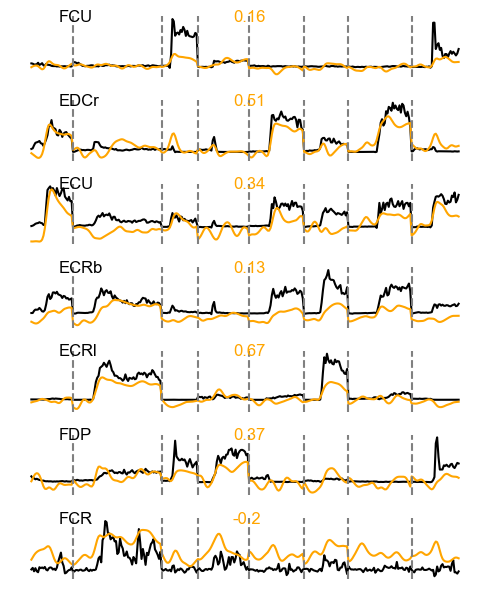

In [8]:
from utils import plot_actual_and_pred_EMG
day0_decoder = np.load('./decoder/Day-0 decoder.npy')
plot_actual_and_pred_EMG('Using day-0 decoder to predict EMGs on day-k', 
                         dayk_spike_, dayk_EMG_, day0_decoder, bin_size, n_lags, 8, r2, dayk_EMG_names, 'orange')

In each panel, the black traces are the actual day-k EMGs, while the orange traces are the EMGs predicted by the decoder. The numbers are the $R^2$ values of the EMG predictions for individual muscles. Gray lines indicate individual trials. From these figures, we could learn that although the predictions for some muscles (ECRl) remain good, the predictions for most muscles are quite different of the real EMGs

## Define the blocks for the Cycle-GAN based aligner

Now we are going to build the Cycle-GAN based aligner described in [Our preprint](https://www.biorxiv.org/content/10.1101/2022.08.26.504777v1). We will train it with a certain number of trials. We will test the performance of the day-0 decoder after aligning day-k data using the Cycle-GAN based aligner. We will use `pytorch` for all the implementations. Since our approach is quite effecient, a CPU is already good enough for the training, while a GPU may not be used.

First let's define the architectures of the generator networks and the discriminator networks. We will write two `python` classes to implement them. 

Unlike the original Cycle-GAN for image translation jobs, we did not use convolutional neural networks. We did not use recurrent neural networks either. Here all the networks are simple feedforward neural networks with a single hidden layer. We added drop-out layers in the networks as it is a widely used neural network training technique.

### The definition of the generator network

The Cycle-GAN generators are shallow feedforward neural networks with one hidden layer. They took N channels of spike firing rates as the input, and output N channels of aligned spike firing rates. 

<img src="./images/generator_network.png" style = "width: 400px" align="left"/>

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

class Generator(nn.Module):
    def __init__(self, input_dim, hidden_dim, drop_out):
        """
        input_dim: the number of input channels.
        hidden_dim: the number of neurons in the hidden layer.
        drop_out: drop-out rate.
        """
        super(Generator, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.drop_out = drop_out
        self.model = nn.Sequential(
            nn.Linear(self.input_dim, self.hidden_dim),
            nn.Dropout(self.drop_out), 
            nn.ReLU(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.Dropout(self.drop_out), 
            nn.ReLU(),
            nn.Linear(self.hidden_dim, self.input_dim),
            nn.ReLU()
        )

    def forward(self, input):
        """
        input: spike firing rate data
        x: transformed spike firing rate data
        """
        x = self.model(input)
        return x

### The definition of the discriminator network

The discriminators are also shallow feedforward neural networks with one hidden layer. The input layer and the hidden layer both have N neurons, while the output layer has 1 neuron, as the output is a class label indicating which distribution the input sample belongs to. 

<img src="./images/discriminator_network.png" style = "width: 350px" align="left"/>

In [10]:
class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim, drop_out):
        """
        input_dim: the number of input channels.
        hidden_dim: the number of neurons in the hidden layer.
        drop_out: drop-out rate.
        """
        super(Discriminator, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.drop_out = drop_out
        self.model = nn.Sequential(
            nn.Linear(self.input_dim, self.hidden_dim),
            nn.Dropout(self.drop_out),
            nn.ReLU(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.Dropout(self.drop_out),
            nn.ReLU(),
            nn.Linear(self.hidden_dim, 1)
        )

    def forward(self, input):
        """
        input: spike firing rate data
        return: a label indicating if the input data is real or fake
        """
        label = self.model(input)
        return label

## Train and test a Cycle-GAN based aligner

The Cycle-GAN aligner is based on the structure proposed in (Zhu et al., 2017). Cycle-GAN consists of two feedforward generator neural networks (generator1 and generator2) and two discriminator networks (discriminator1 and discriminator2), see the figure below. These form two pairs of adversarial networks: generator2 maps data from the day-k domain to the day-0 domain, while discriminator2 aims to distinguish between the day-0 samples and the output of generator2. And in parallel, generator1 maps data in the day-0 domain to the day-k domain, while discriminator1 distinguishes day-k data from output of generator1.

The objective function for network training has two major terms. The first is an adversarial loss, defined for both generator-discriminator pairs. The second term is known as the cycle-consistency loss, which pushes the mappings generator1 and generator2 to become inverses of each other: that is, a sample from one specific domain should be recovered to its original form after going through the cycle composed of the two mappings. As argued by Zhu et al, the introduction of the cycle-consistency loss regularizes the learning of the mapping functions, thereby reducing the search space. In the figure below, the purple arrows through generator2 and generator1 reflect the transformation of each sample from the day-k domain into the day-0 domain by generator2, followed by the recovery from the day-0 domain into the day-k domain by generator1. Likewise, the orange arrows through generator1 and generator2 reflect a transformation from the day-0 domain to the day-k domain and back to the day-0 domain. 

In this case, generator2 is what we need after training.

![cycle_gan_structure](./images/cycle_gan_structure.png)

### Write a function to train a Cycle-GAN based aligner

This function is a little long, since we need to specify the hyper-parameters in it, and need to instantiate the modules of Cycle-GAN, and also need to lead the outputs of each module to the right ports as shown above. Therefore, the codes below are heavily commented.

In [11]:
def train_cycle_gan_aligner(x1, x2, y2, D_params, G_params, training_params, decoder, n_lags, logs = True):
    """
    x1: M1 spike firing rates on day-0. A list, where each item is a numpy array containing the neural data of one trial
    
    x2: M1 spike firing rates on day-k. A list, where each item is a numpy array containing the neural data of one trial
        x2 will be divided into two portions (ratio 3:1), where the first portion will be used to train the aligner, and 
        the second portion will be used as the validation set.
    
    y2: EMGs on day-k. A list, where each item is a numpy array containing the EMGs of one trial. Only a portion of y2
        (those corresponding to the trials used as the validation set) will be used.
    
    D_params: the hyper-parameters determining the structure of the discriminators, a dictionary.
    
    G_params: the hyper-parameters determining the structure of the generators, a dictionary.
    
    training_parameters: the hyper-parameters controlling the training process, a dictionary.
    
    decoder: the day-0 decoder to be tested on the validation set, an array.
    
    n_lags: the number of time lags of the decoder, a number.
    
    logs: to indicate if training logs is needed to be recorded as a .pkl file, a bool.
    
    return: a trained "aligner" (generator) for day-k use.
    """
    #============================================= Specifying hyper-parameters =============================================
    D_hidden_dim = D_params['hidden_dim']
    G_hidden_dim = G_params['hidden_dim']
    loss_type = training_params['loss_type']
    optim_type = training_params['optim_type']
    epochs = training_params['epochs']
    batch_size = training_params['batch_size']
    D_lr = training_params['D_lr']
    G_lr = training_params['G_lr']
    ID_loss_p = training_params['ID_loss_p']
    cycle_loss_p = training_params['cycle_loss_p']
    drop_out_D = training_params['drop_out_D']
    drop_out_G = training_params['drop_out_G']
    
    #============================================= Defining networks ===================================================
    x_dim = x1[0].shape[1]
    generator1, generator2 = Generator(x_dim, G_hidden_dim, drop_out_G), Generator(x_dim, G_hidden_dim, drop_out_G)
    discriminator1, discriminator2 = Discriminator(x_dim, D_hidden_dim, drop_out_D), Discriminator(x_dim, D_hidden_dim, drop_out_D)

    #==================================== Specifying the type of the losses ===============================================
    if loss_type == 'L1':
        criterion_GAN = torch.nn.MSELoss()
        criterion_cycle = torch.nn.L1Loss()
        criterion_identity = torch.nn.L1Loss()
    elif loss_type == 'MSE':
        criterion_GAN = torch.nn.MSELoss()
        criterion_cycle = torch.nn.MSELoss()
        criterion_identity = torch.nn.MSELoss()

    #====================================== Specifying the type of the optimizer ==============================================
    if optim_type == 'SGD':
        gen1_optim = optim.SGD(generator1.parameters(), lr = G_lr, momentum=0.9)
        gen2_optim = optim.SGD(generator2.parameters(), lr = G_lr, momentum=0.9)
        dis1_optim = optim.SGD(discriminator1.parameters(), lr = D_lr, momentum=0.9)
        dis2_optim = optim.SGD(discriminator2.parameters(), lr = D_lr, momentum=0.9)
    elif optim_type == 'Adam':
        gen1_optim = optim.Adam(generator1.parameters(), lr = G_lr)
        gen2_optim = optim.Adam(generator2.parameters(), lr = G_lr)
        dis1_optim = optim.Adam(discriminator1.parameters(), lr = D_lr)
        dis2_optim = optim.Adam(discriminator2.parameters(), lr = D_lr)
    elif optim_type == 'RMSProp':
        gen1_optim = optim.RMSprop(generator1.parameters(), lr = G_lr)
        gen2_optim = optim.RMSprop(generator2.parameters(), lr = G_lr)
        dis1_optim = optim.RMSprop(discriminator1.parameters(), lr = D_lr)
        dis2_optim = optim.RMSprop(discriminator2.parameters(), lr = D_lr)

    #=============================== Split x2 into the actual training set and the validation set ==============================
    #----------- x2_train will be used in Cycle-GAN training -------------
    x2_train = x2[:int(len(x2)*0.75)] # training set
    
    #------- x2_valid and y2_valid will be isolated from training, and used to test the performance of the aligner every 10 trials
    x2_valid, y2_valid = x2[int(len(x2)*0.75):], y2[int(len(x2)*0.75):] # validation set
    
    #================================================  Define data Loaders ====================================================== 
    x1, x2_train = np.concatenate(x1), np.concatenate(x2_train)
    #--------------- loader1 is for day-0 data ---------------------
    loader1 = DataLoader(torch.utils.data.TensorDataset(torch.Tensor(x1)), batch_size = batch_size, shuffle = True)
    #--------------- loader2 is for day-k data in the training set ---------------------
    loader2 = DataLoader(torch.utils.data.TensorDataset(torch.Tensor(x2_train)), batch_size = batch_size, shuffle = True)
    
    #============================================ Training logs =========================================================
    train_log = {'epoch':[], 'batch_idx': [],
                 'loss D1':[], 'loss D2':[], 
                 'loss G1':[], 'loss G2':[],
                 'loss cycle 121':[], 'loss cycle 212':[],
                 'decoder r2 wiener': [],
                 'decoder r2 rnn': []}
    
    #============================================ Preparing to train ========================================================
    generator1.train()
    generator2.train()
    discriminator1.train()
    discriminator2.train()
    aligner_list = []
    mr2_all_list = []

    #================================================== The training loop ====================================================
    for epoch in range(epochs):
        for batch_idx, (data1_, data2_) in enumerate(zip(loader1, loader2)):
            #========================= loader1 and loader2 will yield mini-batches of data when running =========================
            #------ The batches by loader1 will be stored in data1, while the batches by loader2 will be stored in data2 ------
            data1, data2 = data1_[0], data2_[0]
            if data1.__len__() != data2.__len__():
                continue
            #------------ The labels for real samples --------------
            target_real = torch.ones((data1.shape[0], 1), requires_grad = False).type('torch.FloatTensor')
            #------------ The labels for fake samples --------------
            target_fake = torch.zeros((data1.shape[0], 1), requires_grad = False).type('torch.FloatTensor')

            #================================================== Generators ==================================================
            gen1_optim.zero_grad()
            gen2_optim.zero_grad()
            
            #------------ Identity loss, to make sure the generators do not distort the inputs --------------
            same2 = generator1(data2)
            loss_identity2 = criterion_identity(same2, data2)*ID_loss_p
            same1 = generator2(data1)
            loss_identity1 = criterion_identity(same1, data1)*ID_loss_p
            
            #------------ GAN loss for generator1, see the figure right above --------------
            fake2 = generator1(data1)
            pred_fake = discriminator2(fake2)
            loss_GAN2 = criterion_GAN(pred_fake, target_real)
            
            #------------ GAN loss for generator2, see the figure right above --------------
            fake1 = generator2(data2)
            pred_fake = discriminator1(fake1)
            loss_GAN1 = criterion_GAN(pred_fake, target_real)
            
            #------------ Cycle loss, see the figure right above --------------
            recovered1 = generator2(fake2)
            loss_cycle_121 = criterion_cycle(recovered1, data1)*cycle_loss_p
            
            recovered2 = generator1(fake1)
            loss_cycle_212 = criterion_cycle(recovered2, data2)*cycle_loss_p
            
            #----------- Total loss of G, the sum of all the losses defined above -----------
            loss_G = loss_identity1 + loss_identity2 + loss_GAN1 + loss_GAN2 + loss_cycle_121 + loss_cycle_212
            
            #-------- Backward() and step() for generators ---------
            loss_G.backward() 
            gen1_optim.step()
            gen2_optim.step()
            
            #================================================== Discriminator 1 ==================================================
            dis1_optim.zero_grad()
            
            #-------------- Adversarial loss from discriminator 1, see the figure above ------------------
            pred_real = discriminator1(data1)
            loss_D_real = criterion_GAN(pred_real, target_real)
            
            pred_fake = discriminator1(generator2(data2).detach())
            loss_D_fake = criterion_GAN(pred_fake, target_fake)
            
            loss_D1 = (loss_D_real + loss_D_fake)/2
            
            #-------- Backward() and step() for discriminator1 ---------
            loss_D1.backward()
            dis1_optim.step()
            
            #-------------- Adversarial loss from discriminator 2, see the figure above ------------------
            dis2_optim.zero_grad()
            
            pred_real = discriminator2(data2)
            loss_D_real = criterion_GAN(pred_real, target_real)
            
            pred_fake = discriminator2(generator1(data1).detach())
            loss_D_fake = criterion_GAN(pred_fake, target_fake)
            
            loss_D2 = (loss_D_real + loss_D_fake)/2
            
            #-------- Backward() and step() for discriminator2 ---------
            loss_D2.backward()
            dis2_optim.step()
            
            #====================================== save the training logs ========================================
            if logs == True:
                train_log['epoch'].append(epoch)
                train_log['batch_idx'].append(batch_idx)
                train_log['loss D1'].append(loss_D1.item())
                train_log['loss D2'].append(loss_D2.item())
                train_log['loss G1'].append(loss_GAN1.item())
                train_log['loss G2'].append(loss_GAN2.item())
                train_log['loss cycle 121'].append(loss_cycle_121.item())
                train_log['loss cycle 212'].append(loss_cycle_212.item())
                
        #================ Test the aligner every 10 epoches on the validation set, and report every 50 epoches ====================
        if (epoch + 1) % 10 == 0:
            #---------- Put generator2, namely the aligner, into evaluation mode ------------
            generator2.eval()
            
            #---------- Use the trained aligner to transform the trials in x2_valid -----------
            x2_valid_aligned = []
            with torch.no_grad():  
                for each in x2_valid:
                    data = torch.from_numpy(each).type('torch.FloatTensor')
                    x2_valid_aligned.append(generator2(data).numpy())
            
            #--------- Feed the day-0 decoder with x2_valid_aligned to evaluate the performance of the aligner ----------
            x2_valid_aligned_, y2_valid_ = format_data_from_trials(x2_valid_aligned, y2_valid, n_lags)
            pred_y2_valid_ = test_wiener_filter(x2_valid_aligned_, decoder)
            
            #--------- Compute the multi-variate R2 between pred_y2_valid (predicted EMGs) and y2_valid (real EMGs) ----------
            mr2 = r2_score(y2_valid_, pred_y2_valid_, multioutput='variance_weighted')
            if (epoch + 1)%50 == 0:
                print('On the %dth epoch, the R\u00b2 on the validation set is %.2f'%(epoch+1, mr2))
            
            #------- Save the half-trained aligners and the corresponding performance on the validation set ---------
            aligner_list.append(generator2)
            mr2_all_list.append(mr2)
            
            #---------- Put generator2 back into training mode after finishing the evaluation -----------
            generator2.train()
    
    IDX = np.argmax(mr2_all_list) 
    print('The aligner has been well trained on the %dth epoch'%(IDX*10))
    train_log['decoder r2 wiener'] = mr2_all_list
    #============================================ save the training log =================================================
    if logs == True:
        dt_string = datetime.now().strftime("%m_%d_%Y_%H_%M_%S")
        with open('./train_logs/train_log_' + dt_string + '.pkl', 'wb') as fp:
            pickle.dump(train_log, fp)        
    
    return aligner_list[IDX]

### Write a function to test the trained aligner

In [12]:
def test_cycle_gan_aligner(net, dayk_data):
    """
    net: the trained aligner
    dayk_data: the data that needs to be processed by the trained aligner
    """
    #------ Put the net in eval mode ------ #
    aligner = net.eval()
    dayk_aligned = []
    
    #------ Use the trained aligner to process the dayk_data ------#
    with torch.no_grad():  
        for each in dayk_data:
            data_tensor = torch.from_numpy(each).type('torch.FloatTensor')
            dayk_aligned.append(aligner(data_tensor).numpy())
    
    #------ Return the aligned day-k data --------#
    return dayk_aligned

### Specify Hyper-parameters

There are a few hyper-parameters for the training of the Cycle-GAN based aligner. We organized them into 3 `Python` dictionaries:

* D_params:
  - hidden_dim: the number of neurons in the hidden layer for the discriminator networks

* G_params:
  - hidden_dim: the number of neurons in the hidden layer for the generator networks
  
* training_params:
  - loss_type: the type of the loss function, can be *L1* or *MSE*
  - optim_type: the type of the optimizer, can be *SGD*, *Adam*, or *RMSProp*
  - epochs: the number of training epochs
  - batch_size: the size of training batches
  - D_lr: the learning rate for the discriminator networks
  - G_lr: the learning rate for the generator networks
  - ID_loss_p: a scaling factor for the identity loss
  - cycle_loss_p: a scaling factor for the cycle_loss
  - drop_out_D: the drop-out rate for the discriminators
  - drop_out_G: the drop-out rate for the generators

In [13]:
#====================== These parameters controls the architecture of the discriminators =============================
D_params = {}
D_params['hidden_dim'] = int(day0_spike_[0].shape[1])

#============================= These parameters controls the architecture of the generators =============================
G_params = {}
G_params['hidden_dim'] = int(day0_spike_[0].shape[1])

#============================= These parameters are for the training process =============================
training_params = {}
training_params['loss_type'] = 'L1'
training_params['optim_type'] = 'Adam'
training_params['epochs'] = 400
training_params['batch_size'] = 256
training_params['D_lr'] = 0.001*10
training_params['G_lr'] = 0.001
training_params['ID_loss_p'] = 5
training_params['cycle_loss_p'] = 5
training_params['drop_out_D'] = 0.2
training_params['drop_out_G'] = 0.2

### Train a cycle-gan based aligner using the function defined above

The figure below describes how we split the day-0 and day-k datasets for training and testing. Since Cycle-GAN tries to transform day-k data into a form resembling day-0 data, we will need both `day0_spike_` and `dayk_spike_` for the aligner training. We have found that the requirement for the amount of `day0_spike_` is not tight, so we include the first 50% of trials of `day0_spike_` in the training set (blue). We then split the `dayk_spike_` in to two portions, where the 75% of trials are for training, and 25% of trials are for testing (pink). Among the training trials, we further isolate 25% of trials to utilize as the validation set (green). The split of the validation set is implemented in the `train_cycle_gan_aligner` function.

<img src="./images/data_split.png" style = "width: 500px" align="center"/>

In [14]:
#================================ Load the trained day-0 decoder ========================================
day0_decoder = np.load('./decoder/Day-0 decoder.npy')
#======================================== Train the aligner ===============================================
"""
Note for each dataset there are 160 trials. 50% corresponds to 80 trials and 75% corresponds to 120 trials.
The split of the validation set is implemented in the `train_cycle_gan_aligner` function.
"""
aligner = train_cycle_gan_aligner(day0_spike_[:80], dayk_spike_[:120], dayk_EMG_[:120], 
                                  D_params, G_params, training_params, day0_decoder, n_lags, True)

On the 50th epoch, the R² on the validation set is 0.52
On the 100th epoch, the R² on the validation set is 0.58
On the 150th epoch, the R² on the validation set is 0.59
On the 200th epoch, the R² on the validation set is 0.59
On the 250th epoch, the R² on the validation set is 0.59
On the 300th epoch, the R² on the validation set is 0.60
On the 350th epoch, the R² on the validation set is 0.60
On the 400th epoch, the R² on the validation set is 0.60
The aligner has been well trained on the 320th epoch


`aligner` returned by the function `train_cycle_gan_aligner` is the one we want to use. Below we are going to test its performance.

### Test the trained aligner

As mentioned above, we are going to use the last 25% of trials (trials 120 ~ 160) of day-k data for the testing. First, we will need to use the trained aligner stored in the variable `aligner` to process `dayk_spike_`. The processed data are stored in `dayk_spike_aligned`.

We then load the trained day-0 decoder as shown above, then feed the decoder with `dayk_spike_aligned` (need to be formatted first). The outputs are saved in `pred_dayk_EMG_test_`. 

In [15]:
# ======================== Use function `test_cycle_gan_aligner` to process the day-k data =========================#
dayk_spike_aligned = test_cycle_gan_aligner(aligner, dayk_spike_[120:])

# ======================== Load the day-0 decoder, and feed it with the processed day-k data =======================#
day0_decoder = np.load('./decoder/Day-0 decoder.npy')
dayk_spike_aligned_, dayk_EMG_test_ = format_data_from_trials(dayk_spike_aligned, dayk_EMG_[120:], n_lags)
pred_dayk_EMG_test_ = test_wiener_filter(dayk_spike_aligned_, day0_decoder)

# ======================== Compute the multi-variate r2 between the predictions and the real EMGs =====================#
mr2 = r2_score(dayk_EMG_test_, pred_dayk_EMG_test_, multioutput='variance_weighted')
mr2 = format(mr2, '.2f')
print('The day-0 decoder achieved a multi-variate R\u00b2 of %s on day-k after the process of Cycle-GAN'%(mr2))

# ======================== The r2 for individual muscles (for the plotting in the next cell) =========================#
r2 = r2_score(dayk_EMG_test_, pred_dayk_EMG_test_, multioutput='raw_values')

The day-0 decoder achieved a multi-variate R² of 0.60 on day-k after the process of Cycle-GAN


### Let's plot the EMGs predicted by the trained day-0 decoder again, but after day-k spike firing rates being processed by Cycle-GAN

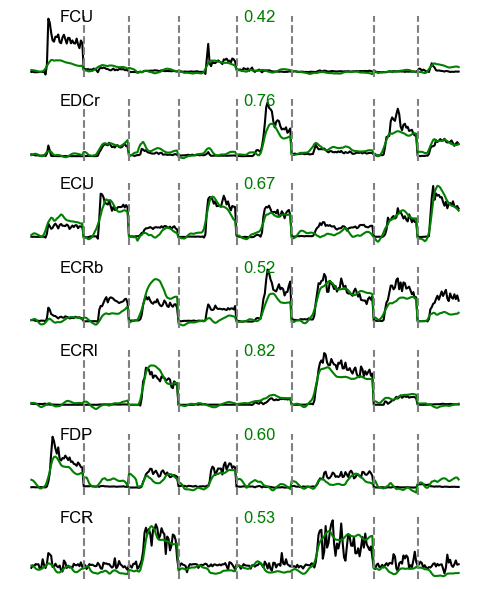

In [16]:
plot_actual_and_pred_EMG('Using day-0 decoder to predict EMGs on day-k after the Cycle-GAN alignment', 
                         dayk_spike_aligned, dayk_EMG_[120:], day0_decoder, bin_size, n_lags, 8, r2, dayk_EMG_names, 'green')

For each panel, the black traces are real EMGs, and the green traces are the predictions by the day-0 decoder after Cycle-GAN alignment. Comparing to a similar figure generated above, the predictions here are much closer to the real signals. Same as above, the numbers are $R^2$ values for individual muscles, and the gray dashed lines separate individual trials.

### Now let's plot the training logs

We will use the function `plot_train_logs` in `utils.py` to load the training log file under the path `./train_logs/` and plot. If one wants to plot them in a log scale, the last option `log_scale` in `plot_train_logs` can be set to *True*.

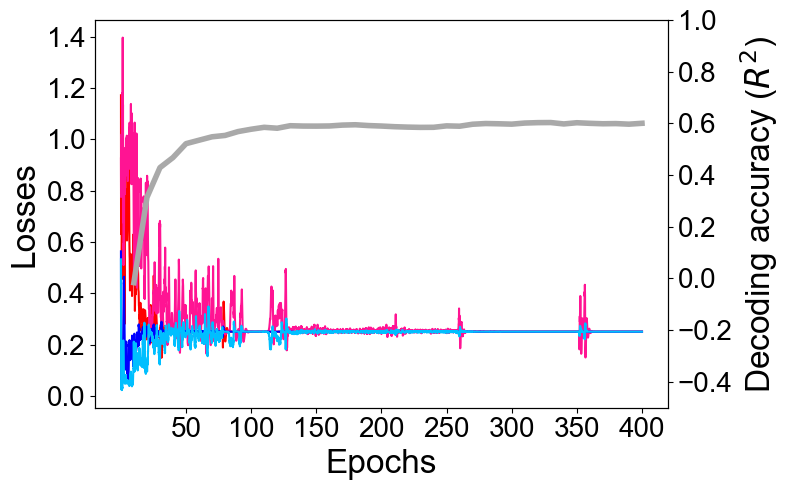

In [17]:
from utils import plot_train_logs
log_file_name = np.sort(fnmatch.filter(os.listdir('./train_logs/'), "*.pkl"))[-1] # the last file by name in the directory is the most recent one
plot_train_logs('./train_logs/', log_file_name, training_params['epochs'], log_scale = False)

The curves with red colors show generator losses across training epochs, while the curves with blue colors show discriminator losses. The gray curve shows the EMG decoding accuracy after Cycle-GAN alignment on the validation set (y-axis on the right side) across every 10 training epochs.